## Pre 3A - Autoencoder (Assignment Preparation)
An autoencoder is not used for *supervised learning*. We will
no longer try to *predict* something about our input.
Instead, an autoencoder is considered a **generative model**:
it learns a distributed *representation* of our training data,
and can even be used to generate new instances of the training data.

An autoencoder model contains two components:

- An **encoder** that takes an image as input, and
  outputs a low-dimensional embedding (representation)
  of the image.
- A **decoder** that takes the low-dimensional embedding,
  and reconstructs the image.

An autoencoder is typically shown like below:

![alt text](https://i2.wp.com/www.statworx.com/wp-content/uploads/mushroom_encoder.png)

Autoencoders contain an encode stage which is similar to what we have seen with our ANNs and CNNs, followed by a decode stage which is just the reverse of the encode stage. In presenting the architecture of autoencoders we will try to use code that we have seen when working with MNIST data.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

#### Architecture
The architecture is very similar to what we have seen in the past, except now the output will be the same size as the input. Notice also that we apply a sigmoid on the output data, this is to scale the output from 0 to 1.

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        encoding_dim = 32
        # encoder
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        # decoder
        self.fc2 = nn.Linear(encoding_dim, 28*28)

    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        x = self.fc1(flattened)
        # sigmoid for scaling output from 0 to 1
        x = F.sigmoid(self.fc2(x))
        return x

#### Training an Autoencoder

How do we train an autoencoder? How do we know what
kind of "encoder" and "decoder" we want?

One observation is that if we pass an image through the encoder,
then pass the result through the decoder, we should get
roughly the same image back. Ideally, reducing the
dimensionality and then generating the image should
give us the same result.

This observation provides us a training strategy: we will
minimize the reconstruction error of the autoencoder
across our training data.
We use a loss function called 'MSELoss', which
computes the square error at every pixel.

Beyond using a different loss function, the training
scheme is roughly the same. Note that in the code below,
we are using a the optimizer called 'Adam'.

We switched to this optimizer not because it is specifically
used for autoencoders, but because this is the optimizer that
people tend to use in practice. Feel free to use Adam for your
other neural networks.

In [29]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            img = img.view(-1, 28 * 28)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [30]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0666
Epoch:2, Loss:0.0598
Epoch:3, Loss:0.0471
Epoch:4, Loss:0.0430
Epoch:5, Loss:0.0386
Epoch:6, Loss:0.0338
Epoch:7, Loss:0.0343
Epoch:8, Loss:0.0326
Epoch:9, Loss:0.0311
Epoch:10, Loss:0.0284
Epoch:11, Loss:0.0231
Epoch:12, Loss:0.0253
Epoch:13, Loss:0.0277
Epoch:14, Loss:0.0230
Epoch:15, Loss:0.0210
Epoch:16, Loss:0.0202
Epoch:17, Loss:0.0198
Epoch:18, Loss:0.0186
Epoch:19, Loss:0.0185
Epoch:20, Loss:0.0173


Just like with our ANN we can have additional layers to make a deep autoencoder, also known as a stacked autoencoder.

## Convolutional Autoencoder
When working with image data it is often better to use a convolutional neural network and take advantage of the spatial relationships. The architecture for the encoder stage of a convolutional autoencoder will consist of standard convolutional layers that we have seen in our previous architectures. The decoder step will be a bit more tricky since we need a way to increase the resolution.  

We need something akin to convolution, but that goes in the *opposite* direction. We will use something called a **transpose convolution**. Transpose convolutions were first called *deconvolutions*, since it is the ``inverse'' of a convolution operation. However, the terminology was confusing since it has nothing to do with the mathematical notion of deconvolution.



### Convolution Transpose

First, let's illustrate how convolution transposes can be 'inverses' of convolution layers.
We begin by creating a convolutional layer in PyTorch. This is the convolution that we will
try to find an ``inverse'' for.

In [31]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=8,
                 kernel_size=5)

To illustrate how convolutional layers work, we'll create a random tensor
and see how the convolution acts on that tensor:

In [32]:
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 8, 60, 60])

A convolution transpose layer with the exact same specifications as above
would have the ``reverse'' effect on the shape.

In [33]:
convt = nn.ConvTranspose2d(in_channels=8,
                           out_channels=8,
                           kernel_size=5)
convt(y).shape # should be same as x.shape

torch.Size([2, 8, 64, 64])

And it does! Notice that the weights of this convolution transpose layer are all
random, and are unrelated to the weights of the original `Conv2d`. So, the layer
`convt`  is not the mathematical inverse of the layer `conv`. However, with training,
the convolution transpose has the potential to learn to act as an approximate
inverse to `conv`.

Here is another example of `convt` in action:

In [34]:
x = torch.randn(32, 8, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 68, 68])

Notice that the width and height of `y` is `68x68`, because the `kernel_size` is 5
and we have not added any padding. You can verify that if we start with a tensor
with resolution `68x68` and applied a `5x5` convolution, we would end up with
a tensor with resolution `64x64`.

In [35]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=16,
                 kernel_size=5)
y = torch.randn(32, 8, 68, 68)
x = conv(y)
x.shape

torch.Size([32, 16, 64, 64])

As before, we can add a padding to our convolution transpose, just like we added
padding to our convolution operations:

In [37]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 64, 64])

More interestingly, we can add a stride to the convolution to increase our resolution!

In [38]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           stride=2,
                           output_padding=1, # needed because stride=2
                           padding=0)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 132, 132])

Our resolution has doubled.

But what is actually happening? Essentially, we are adding a padding of zeros
in between every row and every column of `x`.



### Implementation of a Convolutional Autoencoder

To demonstrate the use of convolution transpose operations,
we will build a **convolutional autoencoder**. Below is an example of a *convolutional* autoencoder that uses solely convolutional layers:

In [39]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [40]:

        #encoder
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.Conv2d(32, 64, 7)

        #decoder
        nn.ConvTranspose2d(64, 32, 7),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),


(ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),)

#### Training a Convolutional Autoencoder

The training of the convolutional autoencoder will be the same as with the fully-connected autoencoder architecture we introduced in the beginning.

In [41]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

Now, we can train this network.

In [42]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0678
Epoch:2, Loss:0.0679
Epoch:3, Loss:0.0580
Epoch:4, Loss:0.0397
Epoch:5, Loss:0.0283
Epoch:6, Loss:0.0202
Epoch:7, Loss:0.0172
Epoch:8, Loss:0.0164
Epoch:9, Loss:0.0154
Epoch:10, Loss:0.0115
Epoch:11, Loss:0.0093
Epoch:12, Loss:0.0094
Epoch:13, Loss:0.0104
Epoch:14, Loss:0.0082
Epoch:15, Loss:0.0076
Epoch:16, Loss:0.0080
Epoch:17, Loss:0.0071
Epoch:18, Loss:0.0066
Epoch:19, Loss:0.0060
Epoch:20, Loss:0.0063


The loss goes down as we train, meaning that our reconstructed images look more
and more like the actual images!

Let's look at the training progression: that is, the reconstructed images at
various points of training:

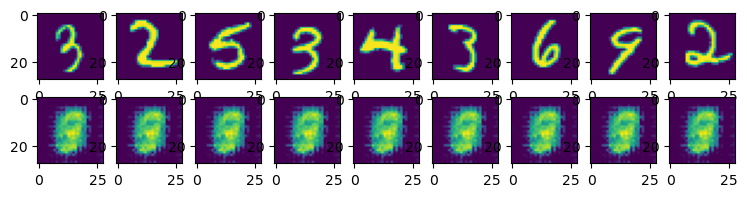

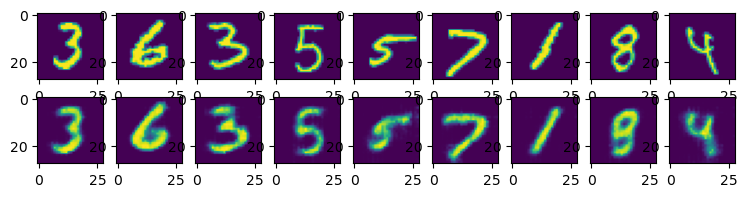

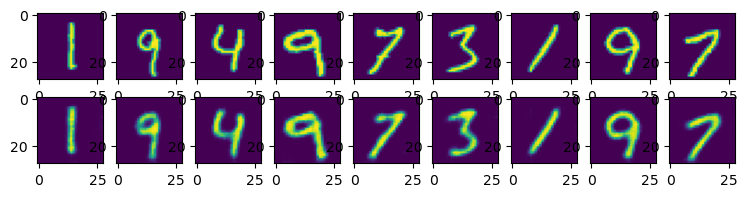

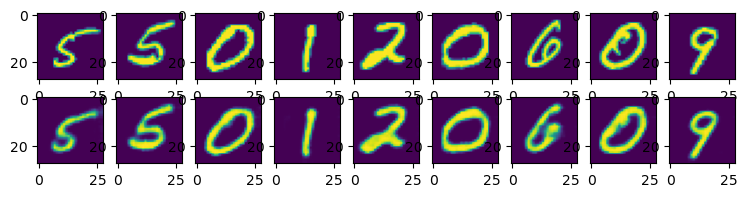

In [43]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

At first, the reconstructed images look nothing like the originals. Rather, the
reconstructions look more like the average of some training images.
As training progresses, our reconstructions are clearer.


## Denoising Autoencoder
We can add noise to our data and see if we can train an autoencoder to clean out the noise added to our images.

In [44]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    noise = 0.5
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data

            # add noise to data
            img_noisy = img + noise * torch.randn(*img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)

            recon = model(img_noisy)
            #img = img.view(-1, 28 * 28)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img_noisy, recon),)
    return outputs

In [45]:
import numpy as np

# train denoising autoencoder
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0679
Epoch:2, Loss:0.0610
Epoch:3, Loss:0.0696
Epoch:4, Loss:0.0690
Epoch:5, Loss:0.0666
Epoch:6, Loss:0.0618
Epoch:7, Loss:0.0519
Epoch:8, Loss:0.0386
Epoch:9, Loss:0.0301
Epoch:10, Loss:0.0296
Epoch:11, Loss:0.0247
Epoch:12, Loss:0.0243
Epoch:13, Loss:0.0220
Epoch:14, Loss:0.0198
Epoch:15, Loss:0.0177
Epoch:16, Loss:0.0199
Epoch:17, Loss:0.0175
Epoch:18, Loss:0.0179
Epoch:19, Loss:0.0169
Epoch:20, Loss:0.0175


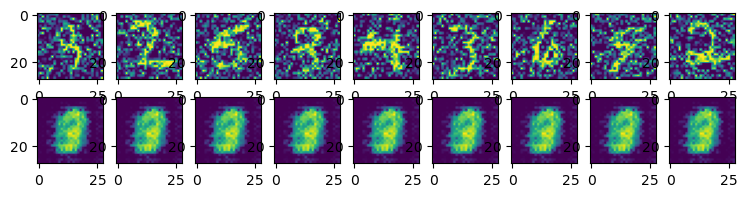

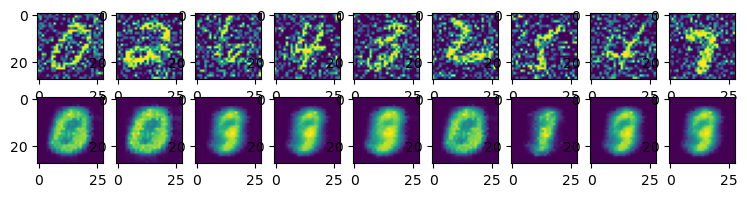

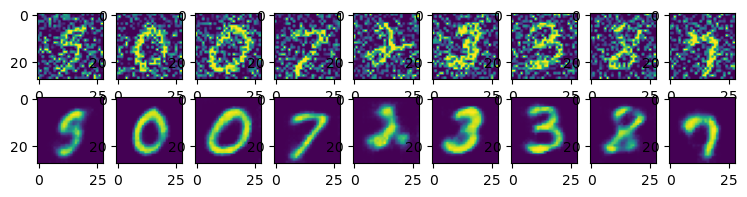

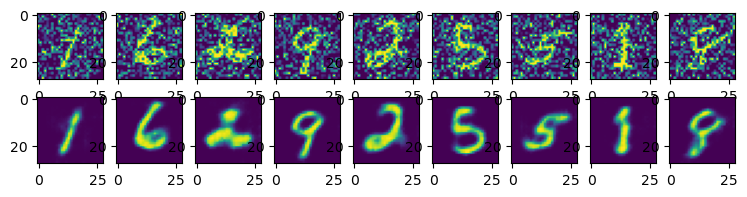

In [46]:
# reconstructed images at various parts of training
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [47]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    noise = 0.5
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data

            img_noisy = img + noise * torch.randn(*img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)

            recon = model(img_noisy)
            #img = img.view(-1, 28 * 28)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img_noisy, recon),)
    return outputs

### Testing on new images

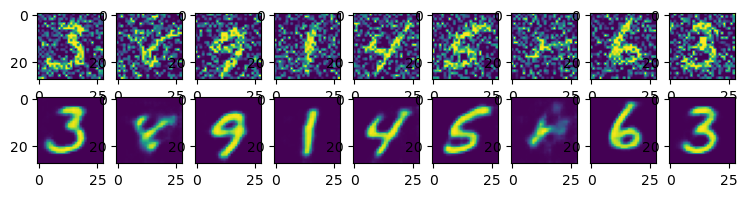

In [ ]:
batch_size = 64

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[4096:4160]

test_loader = torch.utils.data.DataLoader(mnist_data,
                                           batch_size=batch_size,
                                           shuffle=True)

# obtain one batch of test images
dataiter = iter(test_loader) # an iterator the sequentially retrieve batches from test_loader
img, labels = next(dataiter) # get the next batch of images and labels

# add noise to the test images
noise = 0.5
img_noisy = img + noise * torch.randn(*img.shape)
img_noisy = np.clip(img_noisy, 0., 1.)

# get sample outputs
recon = model(img_noisy) # recon = reconstruct
# prep images for display
img_noisy = img_noisy.numpy()
recon = recon.detach().numpy() # converts the output tensor into a NumPy array, detaching it from the computation graph

# reconstructed images at various parts of training
for k in range(1):
    plt.figure(figsize=(9, 2))

    for i, item in enumerate(img_noisy):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Autoencoders are well suited for extracting compressed representations of images and can correct things that don't match the expectation. This approach can be extended to other applications such as handling object occlusion, or filling in missing segments of an image.

## Structure in the Embeddings

Since we are drastically reducing the dimensionality of the image, there has to be
some kind of structure in the embedding space. That is, the network should be able
to "save" space by mapping similar images to similar embeddings.

We will demonstrate the structure of the embedding space by having
some fun with our autoencoders. Let's begin with two images in our training set.
For now, we'll choose images of the same digit.

First load pre-denoising autoencoder architecture and training although you could also do this with the denosing autoencoder.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [23]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0670
Epoch:2, Loss:0.0668
Epoch:3, Loss:0.0493
Epoch:4, Loss:0.0335
Epoch:5, Loss:0.0251
Epoch:6, Loss:0.0190
Epoch:7, Loss:0.0162
Epoch:8, Loss:0.0160
Epoch:9, Loss:0.0150
Epoch:10, Loss:0.0117
Epoch:11, Loss:0.0093
Epoch:12, Loss:0.0098
Epoch:13, Loss:0.0107
Epoch:14, Loss:0.0088
Epoch:15, Loss:0.0078
Epoch:16, Loss:0.0083
Epoch:17, Loss:0.0076
Epoch:18, Loss:0.0071
Epoch:19, Loss:0.0064
Epoch:20, Loss:0.0064


Output two sample images

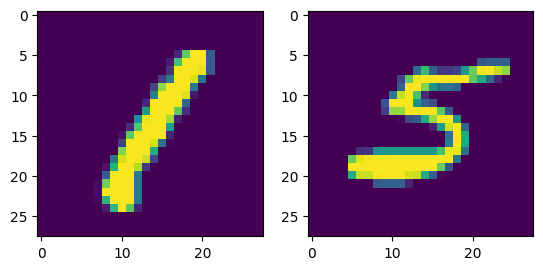

In [24]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

We will then compute the **low-dimensional embeddings** of both images,
by applying the **encoder**:

In [25]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

Now we will do something interesting. Not only are we goign to run the
decoder on those two embeddings `e1` and `e2`, we are also going to **interpolate**
between the two embeddings and decode those as well!

In [26]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

Let's plot the reconstructions of each interpolated values.
The original images are shown below too:

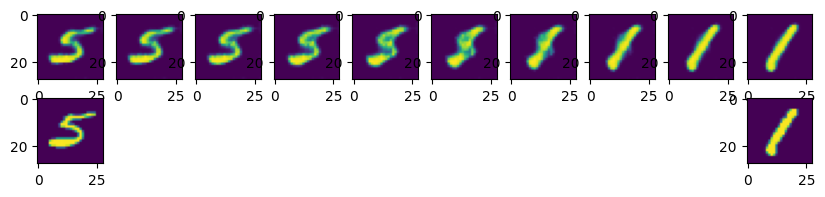

In [27]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

Notice that there is a smooth transition between the two images!
The middle images are likely new, in that there are no training images
that are exactly like any of the generated images.

As promised, we can do the same thing with two images containing
different digits. There should be a smooth transition between
the two digits.

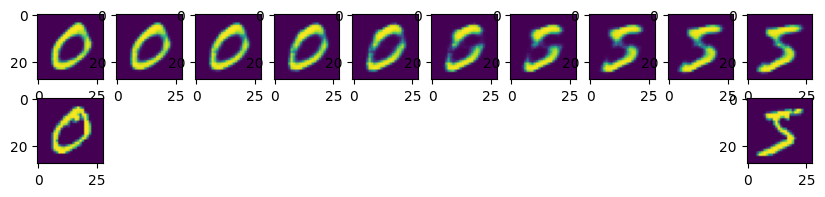

In [28]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

interpolate(0, 1)

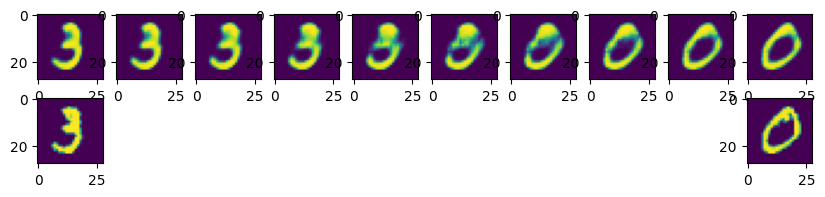

In [29]:
interpolate(1, 10)

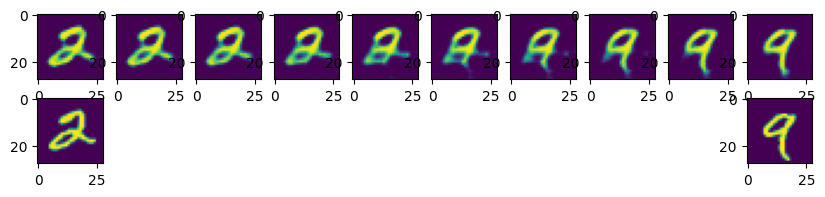

In [30]:
interpolate(4, 5)

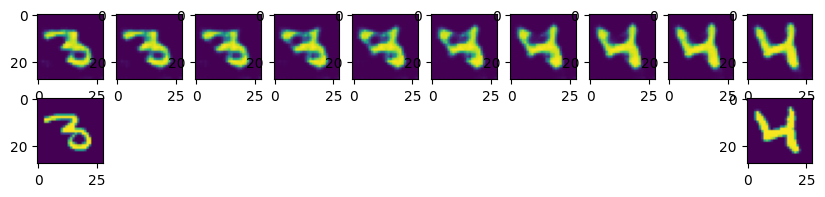

In [31]:
interpolate(20, 30)

In [32]:
def interpolate_pixel(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]

    interpolated_values = []
    for i in range(0, 10):
        e = x1 * (i/10) + x2 * (10-i)/10
        interpolated_values.append(e)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(interpolated_values):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

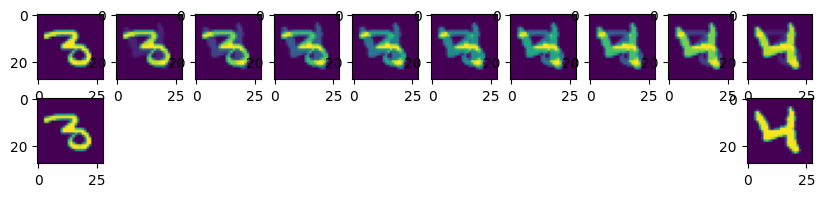

In [33]:
interpolate_pixel(20, 30)

What happens if we randomly initialize in the embedding space?

In [34]:
d = model.decoder(torch.randn(1, 64, 1, 1)).detach().numpy()

In [35]:
d.shape

(1, 1, 28, 28)

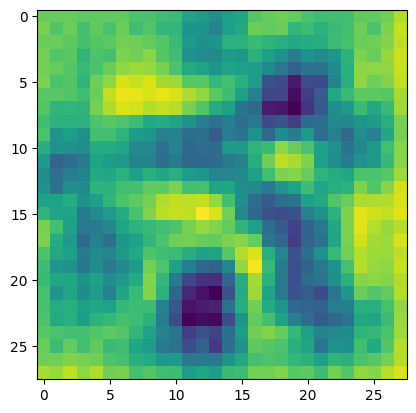

In [36]:
plt.imshow(d[0][0])

The variational autoencoder will allow us to randomly initialize in the embedding space to generate new MNIST-like samples. Provided below is sample code showing how to do that.

## Variational Autoencoder

![alt text](http://kvfrans.com/content/images/2016/08/vae.jpg)

To allow us to sample from the embedding space and generate new images we add a constraint on the encoding network, that forces it to generate latent vectors that roughly follow a unit Gaussian distribution. This constraint is what separates a variational autoencoder from the ones we've seen up to now.

Now generating new images requires that we sample a latent vector from the unit gaussian and pass it into the decoder.

As shown in the figure, we will have encoding and decoding networks similar to what we used before, whether fully-connected or convolutional layers. Then we add two additional linear layers to hold the mean and standard deviation vectors of the embedding space. We will need some way to generate a sampled latent space which will act as input to the decoding network.

We will also need to update our loss function to use Kullback-Leibler divergence to constrain the embedding space to follow a unit Gaussian distribution. You will not be required to know the math behind this.

A demonstration of the variational autoencoder is provided below.

In [37]:
#Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=64, shuffle=True)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)


In [38]:
# dimensions of latent space
zdim = 25

# Variational Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.fc1 = nn.Linear(28 * 28, 350)
        self.relu = nn.ReLU()
        self.fc2m = nn.Linear(350, zdim)  # mu layer
        self.fc2s = nn.Linear(350, zdim)  # sd layer

        # decoder
        self.fc3 = nn.Linear(zdim, 350)
        self.fc4 = nn.Linear(350, 28 * 28)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2m(h1), self.fc2s(h1)

    # reparameterize
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [39]:
# loss function for VAE are unique and use Kullback-Leibler
# divergence measure to force distribution to match unit Gaussian
def loss_function(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 28 * 28
    return bce + kld

In [40]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 1e-3):
    model.train() #train mode
    torch.manual_seed(42)

    train_loader = torch.utils.data.DataLoader(datasets.MNIST('data',
               train=True, download=True, transform=transforms.ToTensor()),
               batch_size = batch_size, shuffle = True)

    optimizer = optim.Adam(model.parameters(), learning_rate)

    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
          img, _ = data

          recon, mu, logvar = model(img)
          loss = loss_function(recon, img, mu, logvar) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [41]:
batch_size = 64

model = Autoencoder()
train(model, num_epochs = 30, batch_size = batch_size)

Epoch:1, Loss:0.1589
Epoch:2, Loss:0.1419
Epoch:3, Loss:0.1227
Epoch:4, Loss:0.1223
Epoch:5, Loss:0.1189
Epoch:6, Loss:0.1103
Epoch:7, Loss:0.1276
Epoch:8, Loss:0.1222
Epoch:9, Loss:0.1165
Epoch:10, Loss:0.1221
Epoch:11, Loss:0.1252
Epoch:12, Loss:0.1131
Epoch:13, Loss:0.1092
Epoch:14, Loss:0.1194
Epoch:15, Loss:0.1122
Epoch:16, Loss:0.1080
Epoch:17, Loss:0.1115
Epoch:18, Loss:0.1140
Epoch:19, Loss:0.1099
Epoch:20, Loss:0.1174
Epoch:21, Loss:0.1043
Epoch:22, Loss:0.1152
Epoch:23, Loss:0.1113
Epoch:24, Loss:0.1095
Epoch:25, Loss:0.1116
Epoch:26, Loss:0.1150
Epoch:27, Loss:0.1277
Epoch:28, Loss:0.1231
Epoch:29, Loss:0.1184
Epoch:30, Loss:0.1142


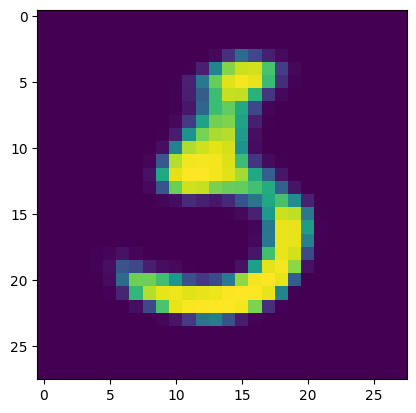

In [42]:
# generate random samples in latent space
model.eval()
sample = torch.randn(64, zdim)
sample = model.decode(sample)

import matplotlib.pyplot as plt
imgs = sample.data.view(64, 28, 28).numpy()
plt.imshow(imgs[4])

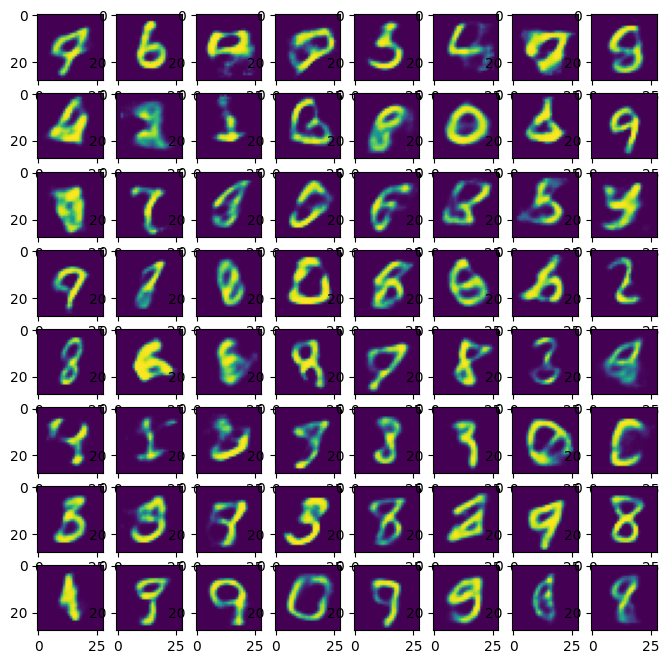

In [43]:
# display images
for k in range(1):
    plt.figure(figsize=(8, 8))

    for i, item in enumerate(imgs):
        plt.subplot(8, 8, i+1)
        plt.imshow(item)

In summary we have learned about several different autoencoders. The different architectures we explored with stacked, convolutional, denoising, and variational autoencoders can be combined to take advantage of their strengths and weaknesses to develop an architecture best suited for your problem.

In this tutorial we didn't go over **semi-supervised learning** which is another very practical application of autoencoders. By learning embeddings from unlabeled data, autoencoders can improve model performance in situations where labeled data may be scarce.